# ARIMA Modeling Continued

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [3]:
def dicky_fuller(df):
    i = 0
    dftest = adfuller(np.diff(df,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(df,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

In [4]:
df_lf = pd.read_csv('../../src/data/df_lf_arima.csv', index_col='time', parse_dates=['time'])
df_lf.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,value
time,,,,,,,,
1996-04-01,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0
1996-04-01,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0
1996-04-01,91982,77494,Katy,TX,Houston,Harris,3,210400.0
1996-04-01,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0
1996-04-01,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0


# ARIMA Model:

In [5]:
zip_code = 60657    # change these params
start_year = 2012   # change these params (1996 or 2010)

df_zip_code = df_lf[(df_lf.RegionName== zip_code) & (df_lf.index.year >= start_year)]

eoti = round(df_zip_code.shape[0] * .8)
df_zip_code_train = df_zip_code.value[:eoti]
df_zip_code_test = df_zip_code.value[eoti:]

print("shape of train and test datasets:", df_zip_code_train.shape, df_zip_code_test.shape, '\n')

shape of train and test datasets: (61,) (15,) 



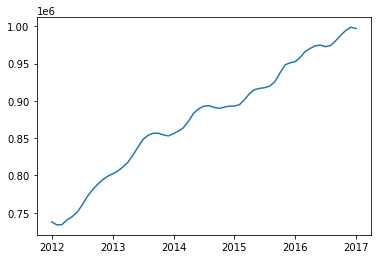

In [6]:
# plotting og zipcode data

plt.plot(df_zip_code_train);

# Upward linear trend

time
1     873116.666667
2     850620.000000
3     855240.000000
4     862080.000000
5     868720.000000
6     873860.000000
7     878320.000000
8     882660.000000
9     887040.000000
10    891900.000000
11    896580.000000
12    898920.000000
Name: value, dtype: float64


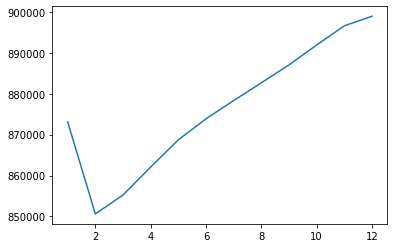

In [7]:
# checking for seasonality within a year, by grouping by month over the entire time period

print(df_zip_code_train.groupby(df_zip_code_train.index.month).mean())
plt.plot(df_zip_code_train.groupby(df_zip_code_train.index.month).mean());

Test Statistic                 -1.557368
p-value                         0.504966
#Lags Used                      8.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64 

 Stationary: False 



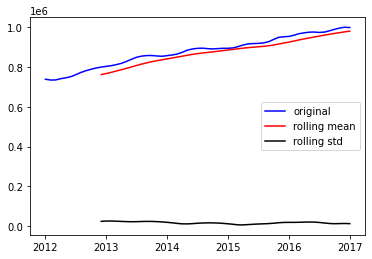

In [14]:
df = df_zip_code_train

roll_mean = df.rolling(window=12).mean()
roll_std = df.rolling(window=12).std()

plt.plot(df, c='b', label='original')
plt.plot(roll_mean, c='r', label='rolling mean')
plt.plot(roll_std, c='black', label='rolling std')
plt.legend(loc='best');


# dickey-fuller test:
dftest = adfuller(df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput, '\n'*2, 'Stationary:', dftest[0] < dftest[4]['5%'], '\n')

In [15]:
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(df)

(0.3192954702644962, True)

In [9]:
dicky_fuller(df_zip_code_train)

3

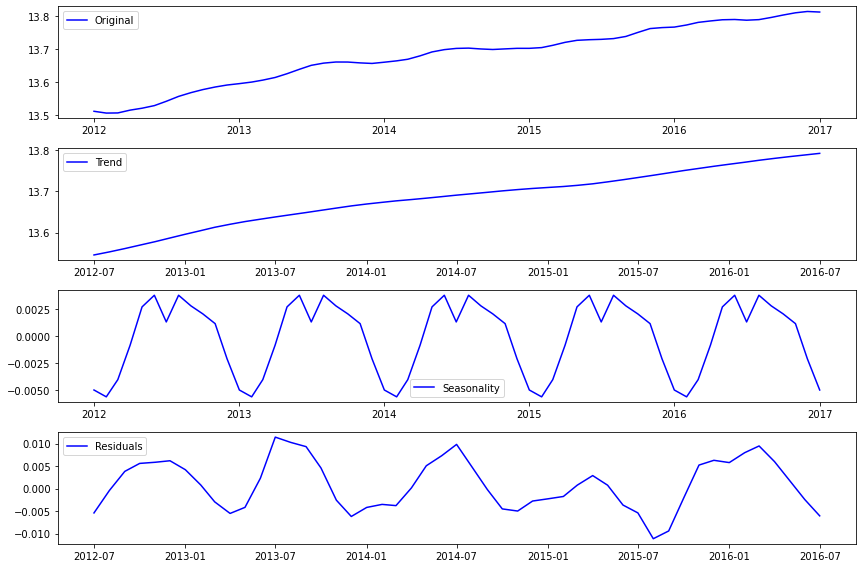

In [10]:
decomposition = seasonal_decompose(np.log(df))
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(df), label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

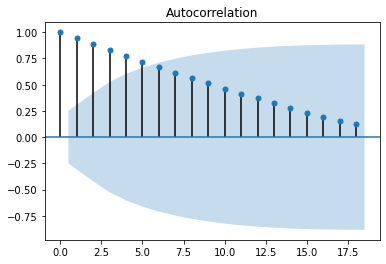

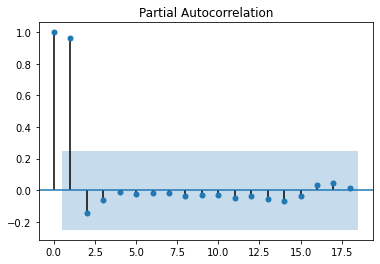

In [11]:
plot_acf(np.diff(df_zip_code_train, 0));

plot_pacf(np.diff(df_zip_code_train, 0));

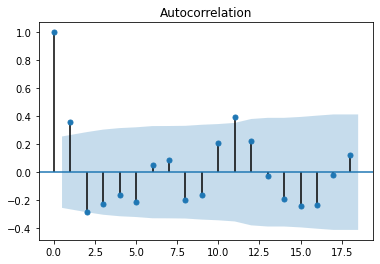

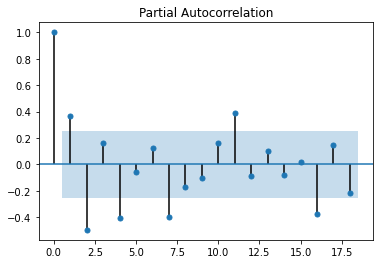

In [54]:
i = 2

plot_acf(np.diff(df_zip_code_train,i)); #ma

plot_pacf(np.diff(df_zip_code_train,i)); #ar

In [52]:
# auto_arima(df_zip_code_train,
#            start_p=1, d=2, start_q=2, 
#            max_p=5, max_d=5, max_q=5, 
#            start_P=0, D=1, start_Q=0, 
#            max_P=5, max_D=5, max_Q=5, 
#            trace=True, )

auto_arima(df_zip_code.value, start_p=0, start_q=0, max_p=6, max_q=3, seasonal=False, trace=True)
# Since the PACF shows the direct effect of previous lags, it helps us choose AR terms
# ACF = MA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1456.956, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1546.174, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1473.231, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1507.149, Time=0.01 sec


/Users/oz/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1460.325, Time=0.18 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.306 seconds


ARIMA(order=(0, 1, 0), scoring_args={})

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   59
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -539.673
Method:                       css-mle   S.D. of innovations           2206.611
Date:                Wed, 11 Nov 2020   AIC                           1089.346
Time:                        18:53:52   BIC                           1099.734
Sample:                    03-01-2012   HQIC                          1093.401
                         - 01-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -30.6452     58.870     -0.521      0.603    -146.027      84.737
ar.L1.D2.value     0.5415      0.130      4.166      0.000       0.287       0.796
ma.L1.D2.value    -0.2254      0.090

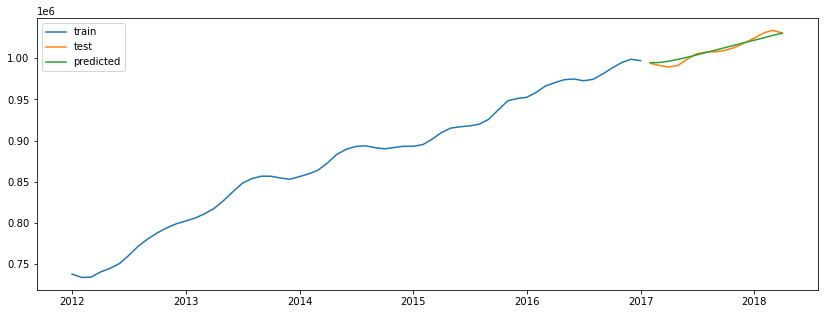

In [48]:
ar, i, ma = [1,2,2] # change these params

model = ARIMA(df_zip_code_train, (ar,i,ma), freq='MS').fit()
y_hat_model = model.predict(typ='levels')
rmse_model = np.sqrt(mean_squared_error(df_zip_code_train[i:], y_hat_model))

test_start_dt = df_zip_code_test.index[0]
test_end_dt = df_zip_code_test.index[-1]
y_hat_model_test = model.predict(start=test_start_dt, end=test_end_dt, typ='levels')
rmse_model_test = np.sqrt(mean_squared_error(df_zip_code_test, y_hat_model_test))

print(model.summary(), '\n')
print('train rmse:', rmse_model, '\n')
print('test rmse:', rmse_model_test, '\n')
print('model aic:', model.aic, '\n')

plt.subplots(figsize=(14,5))
plt.plot(df_zip_code_train, label='train')
plt.plot(df_zip_code_test, label='test')
plt.plot(y_hat_model_test, label='predicted')
plt.legend(loc="upper left");

In [18]:
from statsmodels.tsa.arima_model import ARMA

In [19]:
df_zip_code_train

time
2012-01-01    737700.0
2012-02-01    733700.0
2012-03-01    734000.0
2012-04-01    740300.0
2012-05-01    744600.0
                ...   
2016-09-01    980800.0
2016-10-01    988000.0
2016-11-01    994700.0
2016-12-01    998700.0
2017-01-01    997000.0
Name: value, Length: 61, dtype: float64

2315.209584334684 



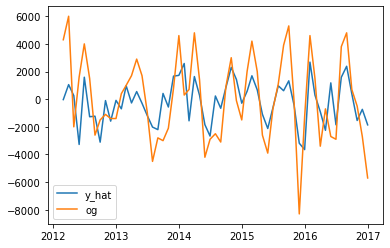

In [44]:
ar, i, ma = [1,2,2] # change these params
df_i = df_zip_code_train.diff().diff().dropna()

model = ARMA(df_i, (ar,ma), freq='MS').fit()
y_hat = model.predict()
rmse_train = np.sqrt(mean_squared_error(df_i, y_hat))
print(rmse_train, '\n')

plt.plot(y_hat, label='y_hat')
plt.plot(df_i, label='og')
# plt.plot(df_zip_code_train, label='60657 train')
plt.legend(loc='best');
# start='2012-03-01', end='2017-01-01'

2611.445449047314 



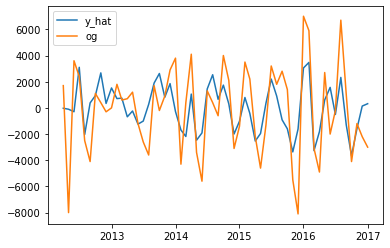

In [55]:
ar, i, ma = [1,3,2] # change these params
df_i = df_zip_code_train.diff().diff().diff().dropna()

model = ARMA(df_i, (ar,ma), freq='MS').fit()
y_hat = model.predict()
rmse_train = np.sqrt(mean_squared_error(df_i, y_hat))
print(rmse_train, '\n')

plt.plot(y_hat, label='y_hat')
plt.plot(df_i, label='og')
# plt.plot(df_zip_code_train, label='60657 train')
plt.legend(loc='best');
# start='2012-03-01', end='2017-01-01'